<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Using Surrogate Series with Pyleoclim

by _Julien Emile-Geay, USC_

Author = {"name": "Julien Emile-Geay", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "julieneg@usc.edu", "orcid": "0000-0001-5920-4751"}

## Preamble

This tutorial gives an overview of the `SurrogateSeries` class: we explain general concept about surrogates, show how to generate and visualize them with `Pyleoclim`, and show how use them to assess the significance of various analyses.


### Goals

- Learn general concepts about surrogates
- Learn how to generate and visualize them with `Pyleoclim`.
    * from_series (show how to obtain parameters)
    * from_param
- Learn how use them to assess the significance of various analyses
 
**Reading Time: 10 min**

### Keywords
Surrogates, Autoregressive model, Long-memory models, Phase scrambling

### Pre-requisites
Some timeseries analysis, ideally 

### Relevant Packages
pyleoclim, pandas, matplotlib, numpy

## Motivation
We start with the Big Question: why? **Why on Earth would Earth Scientists need surrogate series, if they have real (observation-based) series?** The answer is simple: significance. In many areas of the sciences, we compute some kind of number (a "statistic") from the data and we ask: is this meaningful or not? What we usually mean by that is: How likely was it that this result, or something as anomalous as this result, arose by chance? 

The issue is that there are many kinds of "chance", and one needs to be more specific: how likely would you be to observe this result if your data had been replaced with *data that have specific characteristics, but are otherwise random*? That's what surrogate data are: random data that can be used as a [null hypothesis](https://en.wikipedia.org/wiki/Null_hypothesis) for what we are trying to test. There are many ways to be "random". Indeed, surrogate data can be:
1. **generated by Gaussian white noise** (the most common null hypothesis used in science, though not always the most appropriate). 
1. **generated by another, more complex parametric model**, for instance an [autoregressive or moving-average model](https://en.wikipedia.org/wiki/Autoregressive_moving-average_model). If you are new to such models, we strongly advise learning a bit about them (for instance, in Chapter 8 of [this free book](https://figshare.com/articles/book/Data_Analysis_in_the_Earth_Environmental_Sciences/1014336/11)). In essence, they use stochastic (random) processes and a few parameters to capture the key properties of observed timeseries, e.g. their memory (aka persistence).
1. **data obtained by perturbing the original dataset** in ways that modify certain key characteristics, but preserve others. Example of this include the [bootstrap](https://doi.org/10.1201/9780429246593), block bootstrap, [maximum-entropy bootstrap](http://dx.doi.org/10.1016/j.asieco.2006.09.001), and [phase scrambling](https://doi.org/10.1103/PhysRevLett.73.951).  The last method, in turn is rather common in climate science (e.g. [here](http://dx.doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2) and [here](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023GL106585).)
 
  The first two are examples of **parametric** surrogates: they are generated by mathematical models (simple or complex) that have in common an expression of the series values as a function of some parameters. The third kind are **non-parametric** surrogates: they are obtained by manipulating the original data, but involve no such parameters. 

  Both types of surrogates are allowed in `Pyleoclim`, and have different advantages and disadvantages.  
  

## Data description

- TBD

Let us first load necessary packages:

In [2]:
import pyleoclim as pyleo
from matplotlib import pyplot as plt, gridspec
import pandas as pd
import numpy as np
import seaborn as sns

## Creating Surrogates

## Parametric Surrogates
 The first null (Gaussian white noise) is common because it is easy; it has been a convenient choice for over 150 years, lending itself to all kinds of analytical results; that is what most introductory statistics textbooks cover. However, what is easy is seldom what is right, and nowhere is that more true than in the paleosciences. For instance, processes like bioturbation, karst mixing, or isotope diffusion impart memory, so the behavior is no longer white. That is, consecutive values are no longer independent, which undermines 95% of common statistical methods, which assume that data are independent (and identically distributed). 

Instead, one wants surrogates that are simple enough to serve as plausible nulls, but exhibit some kind of memory. Two such models are currently implemented:
- [AR(1) surrogates](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process): this an example of "short-memory" processes, where autocorrelation decays exponentially. 
- [Colored Noise surrogates](https://en.wikipedia.org/wiki/Colors_of_noise) have a power spectrum $S(f)$ in the form of a power law $f^{-\beta}$, with $\beta$ a constant that is frequently near unity or larger (see [Zhu et al (2019)](https://doi.org/10.1073/pnas.1809959116)). The autocorrelation also behaves as a power law, of the form $\gamma(t) = t^{-\beta -1}. 
 
There are two ways of generating such surrogates in `Pyleoclim`: 
1. using given parameters (see `from_param()`)
2. emulating an existing series (see `from_series()`)

In both cases, we first need to request a `SurrogateSeries` object, specify what method we'll use for that, and how many surrogates we want. For instance, to set up 10 AR(1) surrogates:

In [38]:
ar1 = pyleo.SurrogateSeries(method='ar1sim', number=20) 

Next, we specify the model parameters (e-folding time $\tau$, noise variance $\sigma^2$), and how many time steps we want, and plot the result

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'AR(1) synthetic series ($\\tau=2,\\sigma^2=2$)'}, xlabel='Time [years CE]', ylabel='value'>)

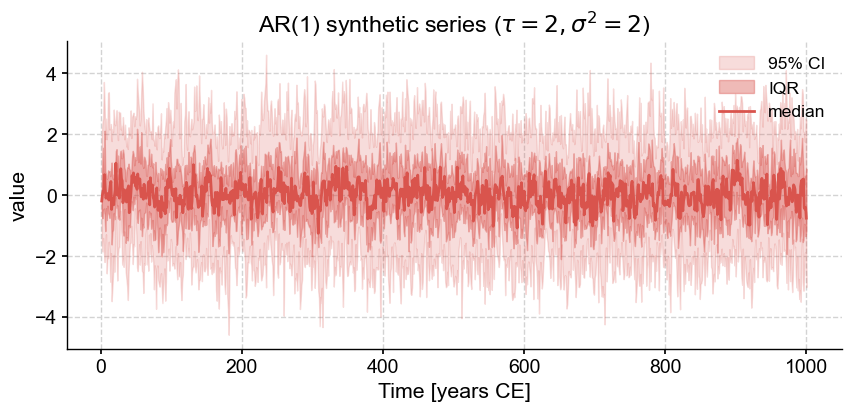

In [39]:
T=1000
ar1.from_param(length=T, param = [2,2])
ar1.plot_envelope(title=rf'AR(1) synthetic series ($\tau={2},\sigma^2={2}$)')

The ensemble is small ($n=20$) so the mean is not flat. With a larger, ensemble, the mean should flatline:


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'AR(1) synthetic series ($\\tau=2,\\sigma^2=2$)'}, xlabel='Time [years CE]', ylabel='value'>)

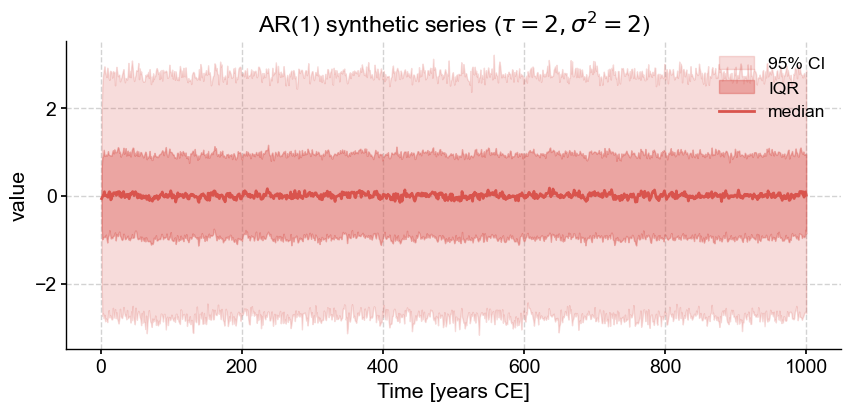

In [40]:
ar1_L = pyleo.SurrogateSeries(method='ar1sim', number=1000) 
ar1_L.from_param(length=T, param = [2,2])
ar1_L.plot_envelope(title=rf'AR(1) synthetic series ($\tau={2},\sigma^2={2}$)')

That is indeed what we observe, and it is a reminder that small ensembles are marred by sampling artifacts: there may appear to be some structure, when in fact it disappears with a large enough sample. Note that `SurrogateSeries` is a child of [EnsembleSeries](./L0_basic_MSES_manipulation.md), so it naturally inherits its attributes, including the `plot_envelope()` function used to visualize this result. 

To generate a pink noise series (aka "shot noise" or "[flicker noise](https://en.wikipedia.org/wiki/Flicker_noise)", characterized by a spectrum that goes as $1/f$), simply use the `CN` method with a slope parameter of 1.0:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Pink noise  ($\\beta=1.0$)'}, xlabel='Time [years CE]', ylabel='value'>)

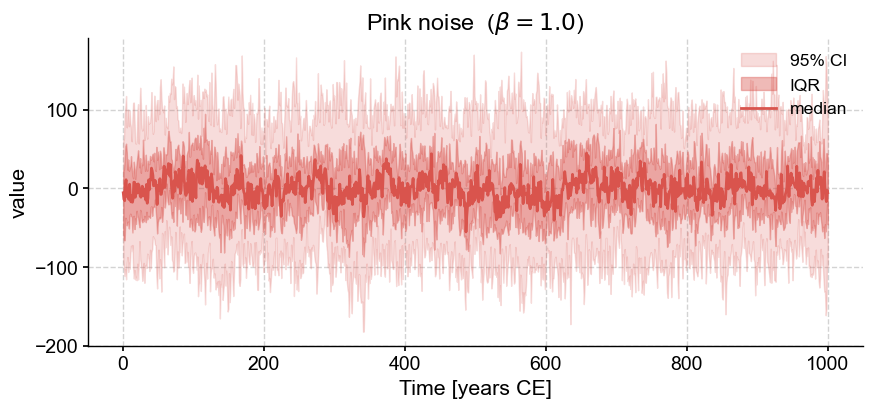

In [41]:
pink = pyleo.SurrogateSeries(method='CN', number=20) 
pink.from_param(length=T, param = [1.0])
pink.plot_envelope(title=rf'Pink noise  ($\beta=1.0$)')

We note that the flicker noise has much larger amplitude, but it's hard to tell what else might be difference by staring at these ensemble plots. Let's compare the spectral densities of these two models:

Performing spectral analysis on individual series: 100%|██████████| 20/20 [00:00<00:00, 33.70it/s]
Performing spectral analysis on individual series: 100%|██████████| 20/20 [00:00<00:00, 33.30it/s]


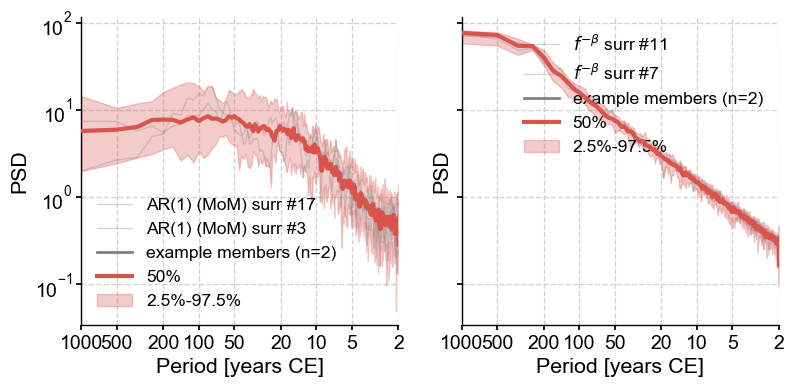

In [42]:
fig, axs = plt.subplots(1,2,figsize=(9,4),sharex=True, sharey=True)
axs = axs.flatten()

for i, model in enumerate([ar1,pink]):
    psd = model.standardize().spectral(method='mtm')
    psd.plot_envelope(ax=axs[i],members_plot_num=2)

This is the main difference between these types of noise : an AR(1) model has a spectrum that flattens at long periods (see the thick red curve on the left, flattening at periods ~20y with this choice of parameters) whereas the flicker noise has power that keeps growing with frequency. Here it flattens at periods of ~200y, but if we generated longer series, it would keep growing indefinitely as the period lengthens, i.e. as we move to the left of the graph. Try it if you're not convinced! 

### Fitting surrogates to a target

Another option, probably more common, is to generate surrogates of an existing series, e.g. the Southern Oscillation Index. We generate 6 surrogates using 3 methods, to keep visualization manageable. 

Text(0.5, 1.0, 'SOI surrogates, phase-randomized')

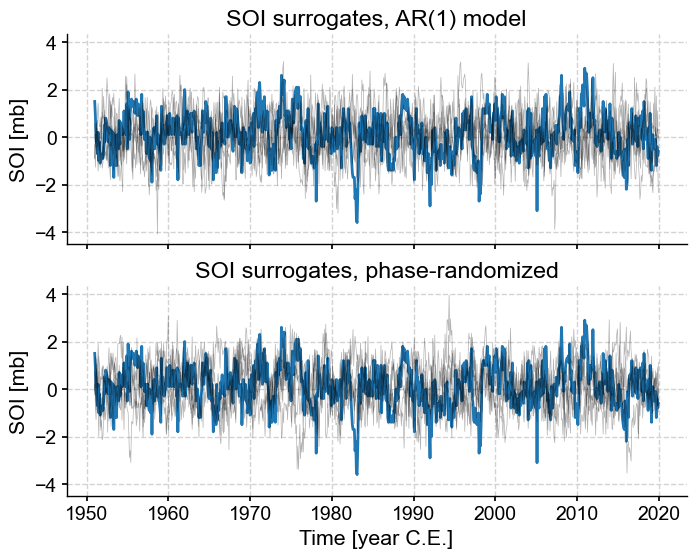

In [2]:
SOI = pyleo.utils.load_dataset('SOI')
fig, ax = plt.subplots(3,1,figsize=(8,9),sharex=True, sharey=True)
for method in ['ar1sim','CN','phaseran']:
    surr = SOI.surrogates(method=method,number=6) 
    surr.from_series(SOI)



fig, ax = plt.subplots(2,1,figsize=(8,6),sharex=True, sharey=True)
SOI_ar1_ens.plot_traces(ax=ax[0],plot_legend=False,num_traces=5,color='black')
SOI.plot(ax=ax[0],legend=False)
ax[0].set_title('SOI surrogates, AR(1) model')
ax[0].set_xlabel('')
SOI_pr_ens.plot_traces(ax=ax[1],plot_legend=False,num_traces=5,color='black')
SOI.plot(ax=ax[1],legend=False)
ax[1].set_title('SOI surrogates, phase-randomized')


## Visualizing LR04 surrogates

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:02<00:00, 93.96it/s]


Text(0.5, 1.0, 'Correlations')

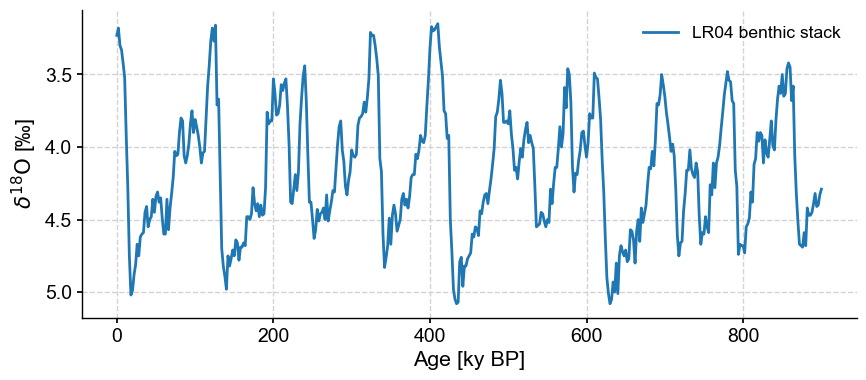

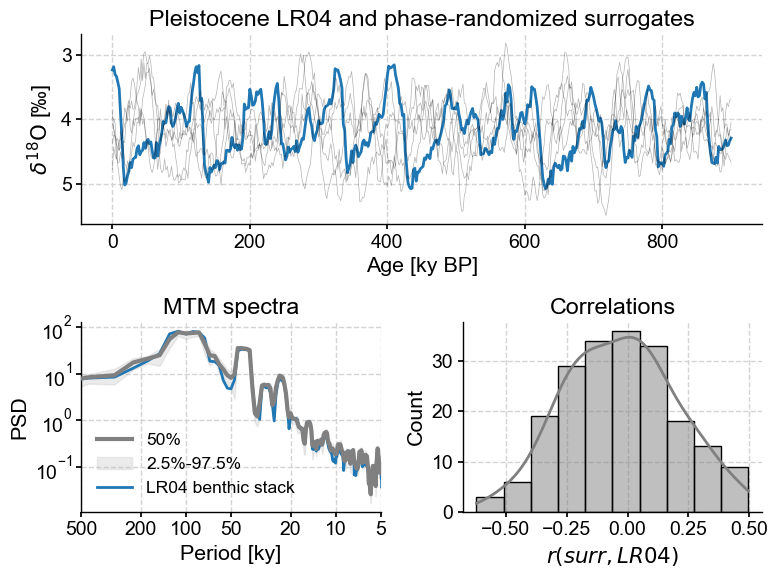

In [5]:


#LR04_2k = LR04.sel(slice(0,900)).interp(step=2) # why is sel() not doing anything??
LR04_2k = LR04.slice([0,900]).interp(step=2) # why is sel() not doing anything??
LR04_2k.plot(invert_yaxis=True)
psd = LR04_2k.spectral(method='mtm',settings={'NW':3})#.signif_test(number=1000)

# generate surrogates
nsurr = 200
LR04pr =  LR04_2k.surrogates(method='phaseran',number=nsurr)

# EnsembleSeries correlation should allow an option without signif_test
from scipy.stats import pearsonr
corr = np.empty((nsurr))
for k, ts in enumerate(LR04pr.series_list):
    corr[k] = pearsonr(LR04_2k.value,ts.value)[0]

# compute spectra
LR04surr =  pyleo.EnsembleSeries(series_list=LR04pr.series_list)
psd_surr =  LR04surr.spectral(method='mtm',settings={'NW':3}) 

# make the figure
fig = plt.figure(tight_layout=True,figsize=(8,6))
ax = {}
gs = gridspec.GridSpec(2, 2)
ax['ts'] = fig.add_subplot(gs[0, :])
LR04surr.plot_traces(ax=ax['ts'],num_traces=5,color='black') # plot_legend argument does not work; also called "legend" in plot() ; should have consistent terminology
LR04_2k.plot(ax=ax['ts'],legend=False,invert_yaxis=True,
             title='Pleistocene LR04 and phase-randomized surrogates')
# plot spectra
ax['spec'] = fig.add_subplot(gs[1, 0])
psd_surr.plot_envelope(ax=ax['spec'],plot_legend=False,curve_clr='gray',
                       members_plot_num=0,shade_clr='silver')
psd.plot(ax=ax['spec'], title='MTM spectra')
# plot correlations
ax['corr'] = fig.add_subplot(gs[1, 1])
sns.histplot(corr,ax=ax['corr'],kde=True,color='gray')
ax['corr'].set_xlabel(r'$r(surr,LR04)$')
ax['corr'].set_title('Correlations')


## Surrogates for significance: LR04 spectral analysis

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='resolution [ky BP]'>)

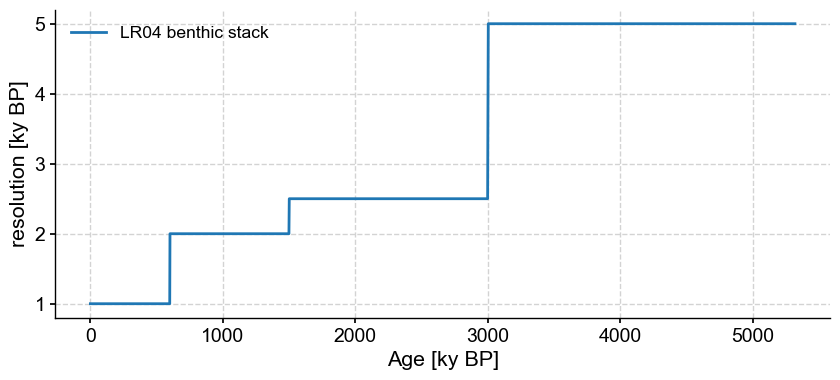

In [3]:
LR04 = pyleo.utils.load_dataset('LR04')
LR04_res = LR04.resolution()
LR04_res.plot()

In [17]:
LR04pl = LR04.slice([0,900]).standardize() # select the Pleistocene for faster computations
freq_custom = pyleo.utils.wavelet.freq_vector_lomb_scargle(LR04pl.time, ofac=4, hifac=0.5)

In [25]:
psd_ls = LR04pl.spectral(settings={'freq':freq_custom})
psd_ls_uar1 = psd_ls.signif_test(method='uar1',number=1000) 

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:26<00:00, 38.30it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

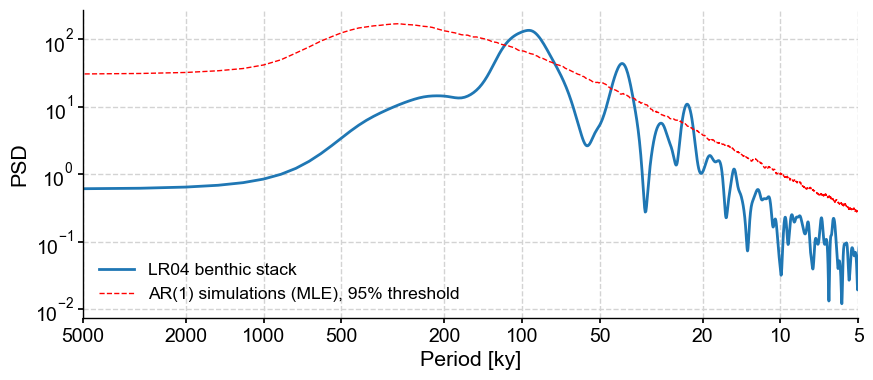

In [26]:
psd_ls_uar1.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

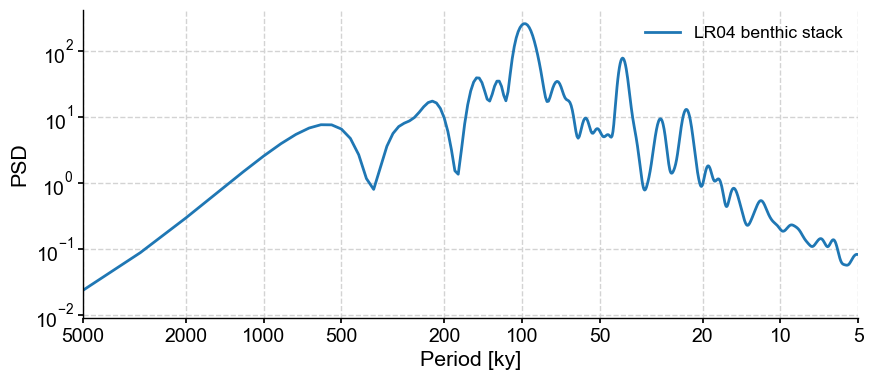

In [28]:
psd_wwz = LR04pl.spectral(method='wwz', settings={'freq':freq_custom})
psd_wwz.plot()
#psd_wwz_uar1 = psd_wwz.signif_test(method='uar1',number=1000) 
#psd_wwz_uar1.plot()

## Takeways

- Surrogates are the basis of most non-parametric tests, particularly anything colloquially labeled "Monte Carlo". 
- `Pyleoclim` has multiple ways of generating surrogates
- They can be used to assess the significance of various results, like spectral peaks, correlations, or causality

## Colored Noise investigations

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [year]', ylabel='PSD'>)

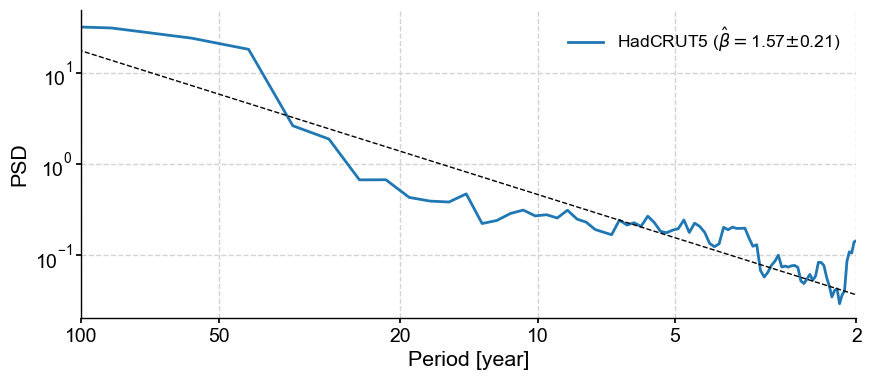

In [9]:
gmst = pyleo.utils.load_dataset('HadCRUT5') 
psd = gmst.spectral(method='mtm').beta_est()
psd.plot()

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:01<00:00, 170.23it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [year]', ylabel='PSD'>)

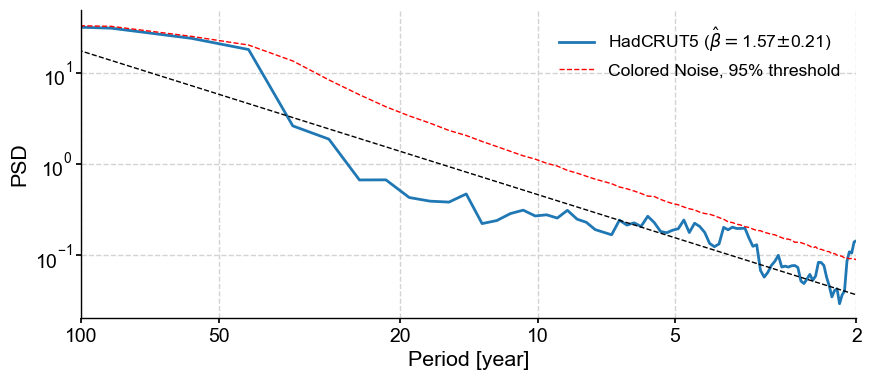

In [10]:
psd_s = psd.signif_test(method='CN')
psd_s.plot()